# IS-4100: NFL Team Performance Analysis using Generalized Linear Models (GLMs)

**Why are GLMs Useful?**
- Flexibility in Modeling Different Types of Data:
  - GLMs can handle various types of response variables:
    - Continuous (Normal distribution)
    - Binary outcomes (Binomial distribution)
    - Counts (Poisson or Negative Binomial distribution)
    - Proportions and more
  - This flexibility allows for modeling data that do not meet the assumptions of traditional linear regression (e.g., non-constant variance, non-normal errors).
- Appropriate for Non-Normal Distributions:
  - Many real-world datasets have response variables that are skewed, bounded, or discrete.
  - GLMs can model these variables appropriately, providing better estimates and inference.
- Interpretability:
  - Coefficients in GLMs can often be interpreted in terms of odds ratios, risk ratios, or rate ratios, which are meaningful in many applied contexts.
- Extensibility:
  - GLMs form the foundation for more advanced models like Generalized Linear Mixed Models (GLMMs), allowing for random effects and hierarchical data structures.
- Modeling Non-Linear Relationships:
  - Through the use of link functions, GLMs can model non-linear relationships between the predictors and the response variable.

In this lab, you will analyze NFL team performance data using Generalized Linear Models (GLMs). You'll utilize the `nfl_data_py` or `nflfastR` to perform your analysis.

**Learning Objectives**
- Data Retrieval: Learn how to fetch and manipulate NFL data using `nfl_data_py` or `nflfastR`.
- Data Preprocessing: Clean and prepare the dataset for modeling.
- GLM Modeling: Understand and apply GLMs to model NFL team performance.
- Interpretation: Interpret the results of your GLM and derive meaningful insights.

**Assignment Overview**

You will perform the following tasks:

- Setup and Data Retrieval
- Data Preprocessing / EDA
  - Build upon feedback and extra functions / methods we have covered in class.
- GLM Modeling
  - Choose an appropriate GLM for modeling team performance.
  - Fit the model and check for assumptions.
- Results Interpretation
  - Analyze the output of your GLM.
  - Discuss the implications of your findings.
- Reporting
  - Summarize your methodology, results, and conclusions in a brief report.

**Extra Resources**
- [nfl_data_py Documentation](https://pypi.org/project/nfl-data-py/)
- [nflfastR Documentation](https://www.nflfastr.com/)
- [nflfastR Data Dictionary](https://www.nflfastr.com/articles/field_descriptions.html)
- [Generalized Linear Models in Python: A Comprehensive Guide](https://statisticseasily.com/generalized-linear-models-in-python/#google_vignette)
- [GLM guide in R](https://albert-rapp.de/posts/14_glms/14_glms)

**Potential Areas to Explore**
- Predicting Touchdown Probability
  - Estimate the probability of a play resulting in a touchdown based on game and play characteristics.
  - Model: Logistic Regression.
- Estimating Player Performance with Poisson Regression
  - Predict the number of tackles a defensive player makes in a game (count data).
- Assessing Penalty Likelihood
  - Predict the probability of a penalty occurring on a play.
  - Model: Logistic Regression
- Evaluating Defensive Sack Rates
  - Analyze factors that contribute to the likelihood of a quarterback sack.
  - Model: Logistic Regression.
- Modeling Over/Under Betting Outcomes
  - Objective: Predict if the total game score will be over or under the bookmaker's line.
  - Model: Logistic Regression.

In [ ]:
## load packages
!pip install nfl_data_py
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import os

## load data and filter data
seasons = range(2016, 2024)
pbp = nfl.import_pbp_data(seasons)
pbp2024 = nfl.import_pbp_data([2024])

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.
2024 done.
Downcasting floats.


##**Data Prep & EDA**

In [ ]:
# Derive a drive-by-drive (dbd) dataframe out of the PBP data
dbd = pbp.groupby(['game_id', 'drive', 'posteam']).agg(
    pass_plays=('play_type', lambda x: (x == 'pass').sum()),
    rush_plays=('play_type', lambda x: (x == 'run').sum()),
    total_plays=('play_type', 'count'),
    total_yards=('yards_gained', 'sum'),
    total_sacks=('sack', 'sum'),
    total_first_downs=('first_down', 'sum'),
    drive_ended_with_score=('drive_ended_with_score', 'max'), # Hold the "drive_ended_with_score" field available in the PBP data
    total_td=('touchdown', 'sum'),
    total_made_field_goals=('field_goal_result', lambda x: (x == 'made').sum())
).reset_index()

# Same thing but for 2024 specific data
dbd2024 = pbp2024.groupby(['game_id', 'drive', 'posteam']).agg(
    pass_plays=('play_type', lambda x: (x == 'pass').sum()),
    rush_plays=('play_type', lambda x: (x == 'run').sum()),
    total_plays=('play_type', 'count'),
    total_yards=('yards_gained', 'sum'),
    total_sacks=('sack', 'sum'),
    total_first_downs=('first_down', 'sum'),
    drive_ended_with_score=('drive_ended_with_score', 'max'),
    total_td=('touchdown', 'sum'),
    total_made_field_goals=('field_goal_result', lambda x: (x == 'made').sum())
).reset_index()
dbd2024.head()

,game_id,drive,posteam,pass_plays,rush_plays,total_plays,total_yards,total_sacks,total_first_downs,drive_ended_with_score,total_td,total_made_field_goals
0,2024_01_ARI_BUF,1.0,ARI,6,7,15,60.0,1.0,5.0,1.0,1.0,0
1,2024_01_ARI_BUF,2.0,BUF,2,2,5,16.0,1.0,2.0,0.0,0.0,0
2,2024_01_ARI_BUF,3.0,ARI,6,3,10,60.0,0.0,3.0,1.0,0.0,1
3,2024_01_ARI_BUF,4.0,BUF,2,6,12,60.0,1.0,4.0,1.0,0.0,1
4,2024_01_ARI_BUF,5.0,ARI,8,5,15,71.0,0.0,6.0,1.0,1.0,0


In [ ]:
# Add the starting field position field
# Filter the first play of each drive
first_play_of_drive = pbp[pbp['play_id'] == pbp['drive_play_id_started']][['game_id', 'drive', 'posteam', 'yardline_100']]

# Rename
first_play_of_drive.rename(columns={'yardline_100': 'yds_to_endzone'}, inplace=True)

# Merge starting field position into the dbd dataframe
dbd = dbd.merge(first_play_of_drive, on=['game_id', 'drive', 'posteam'], how='left')

# Add 'field_position' field that marks drives that begin at mid field or in opponent's territory as "plus", everything else as "normal"
dbd['field_position'] = np.where(dbd['yds_to_endzone'] <= 50, 'plus', 'normal')

# Same thing but for 2024
first_play_of_drive = pbp2024[pbp2024['play_id'] == pbp2024['drive_play_id_started']][['game_id', 'drive', 'posteam', 'yardline_100']]

first_play_of_drive.rename(columns={'yardline_100': 'yds_to_endzone'}, inplace=True)

dbd2024 = dbd2024.merge(first_play_of_drive, on=['game_id', 'drive', 'posteam'], how='left')

dbd2024['field_position'] = np.where(dbd2024['yds_to_endzone'] <= 50, 'plus', 'normal')

dbd2024.head()

,game_id,drive,posteam,pass_plays,rush_plays,total_plays,total_yards,total_sacks,total_first_downs,drive_ended_with_score,total_td,total_made_field_goals,yds_to_endzone,field_position
0,2024_01_ARI_BUF,1.0,ARI,6,7,15,60.0,1.0,5.0,1.0,1.0,0,35.0,plus
1,2024_01_ARI_BUF,2.0,BUF,2,2,5,16.0,1.0,2.0,0.0,0.0,0,35.0,plus
2,2024_01_ARI_BUF,3.0,ARI,6,3,10,60.0,0.0,3.0,1.0,0.0,1,71.0,normal
3,2024_01_ARI_BUF,4.0,BUF,2,6,12,60.0,1.0,4.0,1.0,0.0,1,35.0,plus
4,2024_01_ARI_BUF,5.0,ARI,8,5,15,71.0,0.0,6.0,1.0,1.0,0,35.0,plus


## Which teams in 2024 are most successful in converting "plus" field position into TD's?

In [ ]:
# Filter 2024 dataset to only drives that are "plus" (midfield or closer to EZ)
plus_field_position_drives_2024 = dbd2024[dbd2024['field_position'] == 'plus']

# Group by team, calculate the number of "plus" drives and the number of TD's
team_td_conversion = plus_field_position_drives_2024.groupby('posteam').agg(
    total_plus_drives=('drive', 'count'),
    total_plus_tds=('total_td', 'sum')
).reset_index()

# Calculate TD conversion rate
team_td_conversion['td_conversion_rate'] = team_td_conversion['total_plus_tds'] / team_td_conversion['total_plus_drives']

# Descending order
team_td_conversion = team_td_conversion.sort_values(by='td_conversion_rate', ascending=False)

team_td_conversion.head(32)

,posteam,total_plus_drives,total_plus_tds,td_conversion_rate
10,DET,28,11.0,0.392857
22,NO,44,17.0,0.386364
6,CIN,37,14.0,0.378378
25,PHI,31,11.0,0.354839
31,WAS,37,13.0,0.351351
29,TB,35,12.0,0.342857
5,CHI,36,12.0,0.333333
3,BUF,37,12.0,0.324324
1,ATL,38,12.0,0.315789
20,MIN,26,8.0,0.307692


<Axes: xlabel='total_plus_drives', ylabel='total_plus_tds'>

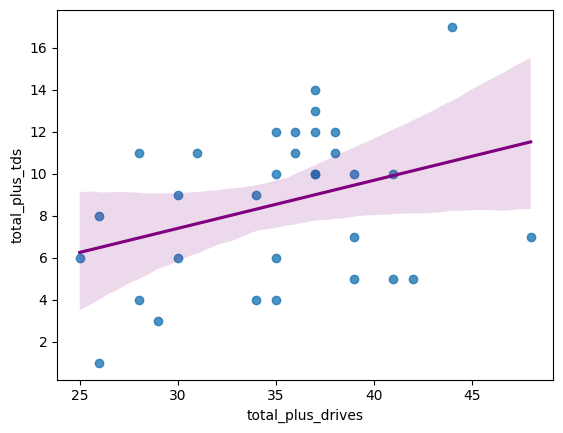

In [ ]:
sns.regplot(
    data = team_td_conversion,
    x = 'total_plus_drives',
    y = 'total_plus_tds',
    line_kws={'color': 'purple'}
)

##Percentage of Drives ending with Points by Starting Field Position (Yds to End Zone)

In [ ]:
fp_dpp = dbd.groupby('yds_to_endzone').agg(
    drive_points_pct=('drive_ended_with_score', 'mean')
).reset_index()

# Check the result
fp_dpp.head()

,yds_to_endzone,drive_points_pct
0,1.0,0.965517
1,2.0,0.916667
2,3.0,0.939394
3,4.0,0.818182
4,5.0,0.869565


In [ ]:
fp_dpp.tail()

,yds_to_endzone,drive_points_pct
94,95.0,0.300330
95,96.0,0.280576
96,97.0,0.283186
97,98.0,0.258065
98,99.0,0.284722


<Axes: xlabel='yds_to_endzone', ylabel='drive_points_pct'>

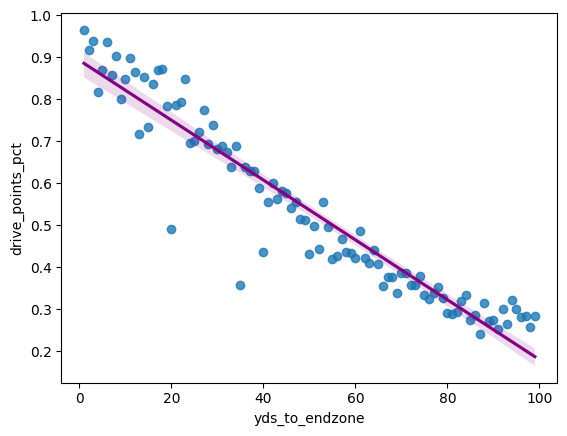

In [ ]:
sns.regplot(
    data = fp_dpp,
    x = 'yds_to_endzone',
    y = 'drive_points_pct',
    line_kws={'color': 'purple'}
)

##Percentage of Drives ending with TD's by Starting Field Position (Yds to End Zone)

<Axes: xlabel='yds_to_endzone', ylabel='drive_td_pct'>

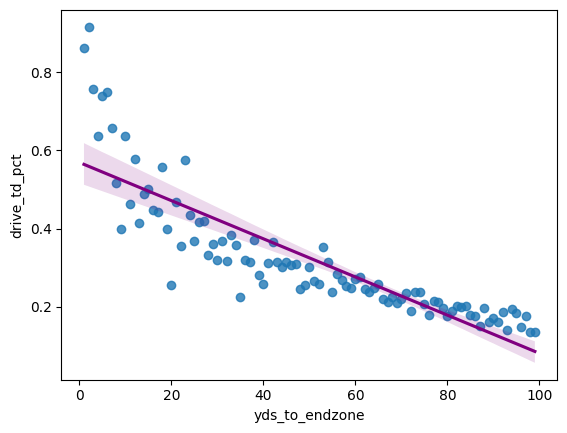

In [ ]:
fp_tdp = dbd.groupby('yds_to_endzone').agg(
    drive_td_pct=('total_td', 'mean')
).reset_index()

sns.regplot(
    data = fp_tdp,
    x = 'yds_to_endzone',
    y = 'drive_td_pct',
    line_kws={'color': 'purple'}
)

##Percentage of Drives ending with FG's by Starting Field Position (Yds to End Zone)

<Axes: xlabel='yds_to_endzone', ylabel='drive_fgm_pct'>

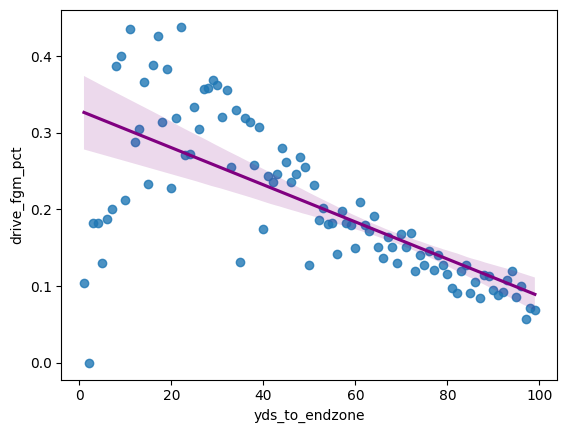

In [ ]:
fp_fgp = dbd.groupby('yds_to_endzone').agg(
    drive_fgm_pct=('total_made_field_goals', 'mean')
).reset_index()

sns.regplot(
    data = fp_fgp,
    x = 'yds_to_endzone',
    y = 'drive_fgm_pct',
    line_kws={'color': 'purple'}
)

##**GLM #1**: drive_ended_with_score ~ total_plays

In [ ]:
glm = smf.glm(
    formula = 'drive_ended_with_score ~ total_plays',
    data = dbd,
    family = sm.families.Binomial()
).fit()

glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Generalized Linear Model Regression Results                    
==================================================================================
Dep. Variable:     drive_ended_with_score   No. Observations:                49070
Model:                                GLM   Df Residuals:                    49068
Model Family:                    Binomial   Df Model:                            1
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -26987.
Date:                    Thu, 17 Oct 2024   Deviance:                       53974.
Time:                            19:38:58   Pearson chi2:                 5.09e+04
No. Iterations:                         4   Pseudo R-squ. (CS):             0.2032
Covariance Type:                nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -2.7726      0.027   -101.347      0.000      -2.826      -2.719
total_plays     0.3014      0.003     91.251      0.000       0.295       0.308
===============================================================================
"""

- While play totals of a drive are a statistically strong predictor of a drive ending in points, the model's low R-squared, very high deviance and significantly negative log-likelihood tells me that it only explains a small portion of the variance and the model could be much better with more significant variables

<Axes: xlabel='total_plays', ylabel='drive_ended_with_score'>

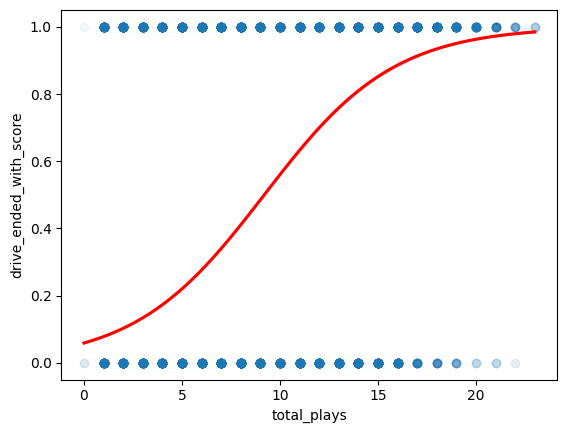

In [ ]:
# log plot
sns.regplot(
    data = dbd,
    x = 'total_plays',
    y = 'drive_ended_with_score',
    logistic = True,
    line_kws={'color': 'red'},
    scatter_kws = {'alpha': 0.05}
)

Accuracy: 0.74
Confusion Matrix:
[[5360  724]
 [1843 1848]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.88      0.81      6084
         1.0       0.72      0.50      0.59      3691

    accuracy                           0.74      9775
   macro avg       0.73      0.69      0.70      9775
weighted avg       0.73      0.74      0.72      9775



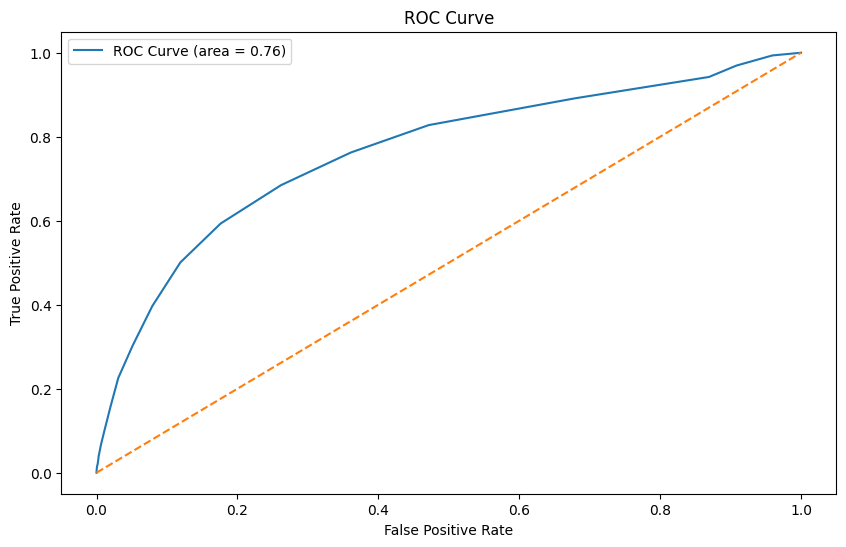

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

dbd.dropna(inplace=True)

X = dbd[['total_plays']]
y = dbd['drive_ended_with_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logreg = LogisticRegression(max_iter=1000)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

y_pred_proba = logreg.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

- The model has no problem identifying drives that won't result in points, but has a harder time accurately predicting drives that will result in points

##**GLM #2**: Multi-Factor

In [ ]:
glm2 = smf.glm(
    formula = 'drive_ended_with_score ~ pass_plays + '
              'rush_plays + total_yards + total_sacks + '
              'total_first_downs + yds_to_endzone',
    data = dbd,
    family = sm.families.Binomial()
).fit()

glm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Generalized Linear Model Regression Results                    
==================================================================================
Dep. Variable:     drive_ended_with_score   No. Observations:                48873
Model:                                GLM   Df Residuals:                    48866
Model Family:                    Binomial   Df Model:                            6
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -17252.
Date:                    Thu, 17 Oct 2024   Deviance:                       34504.
Time:                            19:40:25   Pearson chi2:                 5.66e+04
No. Iterations:                         6   Pseudo R-squ. (CS):             0.4626
Covariance Type:                nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.8663      0.040    -21.792      0.000      -0.944      -0.788
pass_plays           -0.3907      0.009    -41.948      0.000      -0.409      -0.372
rush_plays           -0.2424      0.009    -26.005      0.000      -0.261      -0.224
total_yards           0.0558      0.001     54.715      0.000       0.054       0.058
total_sacks          -0.1493      0.033     -4.480      0.000      -0.215      -0.084
total_first_downs     0.9530      0.021     46.006      0.000       0.912       0.994
yds_to_endzone       -0.0267      0.001    -39.530      0.000      -0.028      -0.025
=====================================================================================
"""

- More rush plays during a drive decrease the likelihood of scoring, but to a lesser extent than pass plays
- Beginning field position doesn't have quite the impact on a driving scoring or not as I thought it would

##**Takeaways**

- The Saints, despite having the 2nd biggest sample size, also convert "plus" field position into TD's at the 2nd highest rate. In spite of this, they are only 2-4.

- The Chargers have only converted 1 of 26 (0.04%) "plus" field position opportunities into TD's. This is reflected in their offensive struggles, but their defense has carried them to a 3-2 record so far.

- Passing the ball excessively can stall a drive out moreso than running the ball excessively.
     - While pass plays tend to have a higher ceiling, the downside of passing is you are exposed to more  outcomes that are extremely hurtful to a drives' chance at success: an INT, a sack, a strip-sack fumble, and an incomplete pass. A rushing play only faces the potential consequences of a fumble and a higher chance at a loss of yardage.